# (Generalized) Linear and Hierarchical Linear Models in PyMC3

In [1]:
import arviz as az
import bambi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import xarray as xr

from numpy.random import default_rng
from statsmodels.formula.api import glm as glm_sm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Linear Regression

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [3]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x * true_slope + rng.normal(scale=0.5, size=size)
data = {"x": x, "y": y}

In [4]:
model = bambi.Model("y ~ x", pd.DataFrame.from_dict(data))
results = model.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [5]:
plt.figure(figsize=(5, 5))
plt.plot(x, y, "x")
pm.plot_posterior_predictive_glm(results)

/Users/almostmeenal/opt/anaconda3/envs/pymc3/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


## Robust GLM

Lets try the same model but with a few outliers in the data.

In [6]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x * true_slope + rng.normal(scale=0.5, size=size)
data = {"x": x, "y": y}

x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

In [7]:
model = bambi.Model("y ~ x", pd.DataFrame.from_dict(data_outlier))
results = model.fit(draws=1000)
results

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [8]:
plt.figure(figsize=(5, 5))
plt.plot(x, y, "x")
pm.plot_posterior_predictive_glm(results)

/Users/almostmeenal/opt/anaconda3/envs/pymc3/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

In [9]:
family = bambi.Family(
    "t", prior=bambi.Prior("StudentT", lam=1, nu=1.5), link="identity", parent="mu"
)

model = bambi.Model(
    "y ~ x",
    pd.DataFrame.from_dict(data_outlier),
    priors={"common": bambi.Prior("Uniform", lower=0, upper=20)},
    family=family,
)

In [10]:
results = model.fit(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


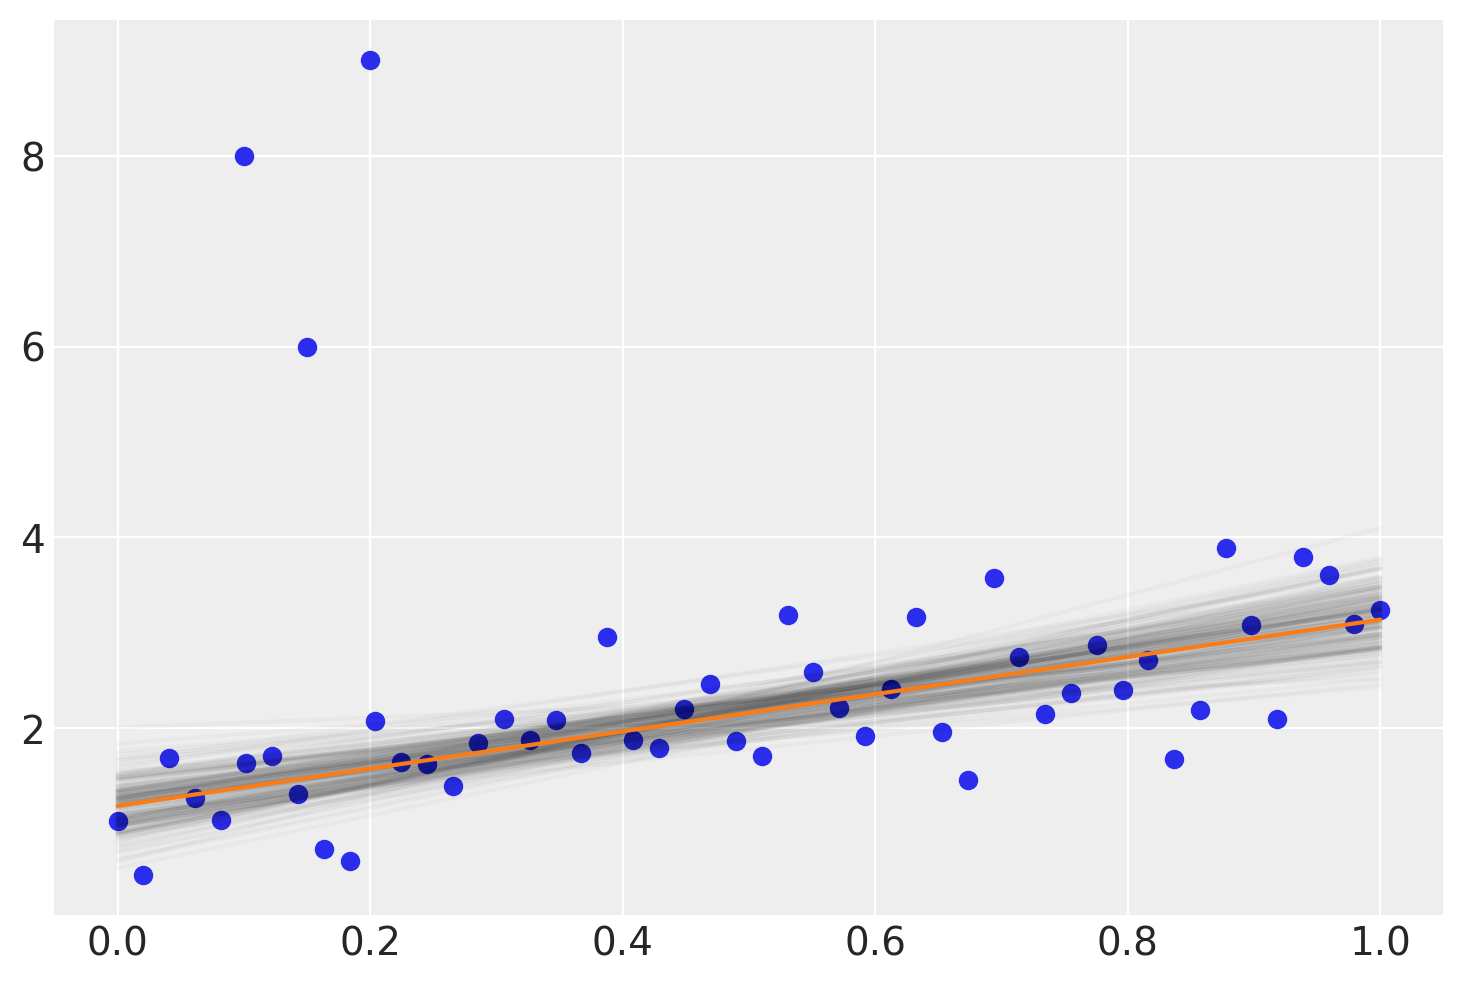

In [13]:
# x = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
# mu_pred = fitted.posterior["Intercept"] + fitted.posterior["x"] * x
# mu_mean = mu_pred.mean(dim=("chain", "draw"))
# plt.scatter(x_out, y_out)
# plt.plot(x_seq, mu_pred.stack(sample=("chain", "draw")), color="black", alpha=0.025)
# plt.plot(x_seq, mu_mean, color = "C1");
fitted = results
x = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
mu_pred = fitted.posterior["Intercept"] + fitted.posterior["x"] * x
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:200]
plt.scatter(x_out, y_out)
plt.plot(x, mu_plot.isel(sample=random_subset), color="black", alpha=0.025)
plt.plot(x, mu_mean, color="C1");

## Hierarchical GLM

In [14]:
try:
    sat_data = pd.read_csv("../data/Guber1999data.txt")
except:
    sat_data = pd.read_csv(pm.get_data("Guber1999data.txt"))

In [15]:
grp_mean = bambi.Prior("Normal", mu=0, sigma=10)
grp_sd = bambi.Prior("HalfCauchy", beta=5)

priors = {
    "Intercept": bambi.Prior("Normal", mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std()),
    "1|spend": bambi.Prior("Normal", mu=grp_mean, sigma=grp_sd),
    "1|stu_tea_rat": bambi.Prior("Normal", mu=grp_mean, sigma=grp_sd),
    "1|salary": bambi.Prior("Normal", mu=grp_mean, sigma=grp_sd),
    "1|prcnt_take": bambi.Prior("Normal", mu=grp_mean, sigma=grp_sd),
}

In [16]:
model = bambi.Model(
    "sat_t ~ (1|spend) + (1|stu_tea_rat) + (1|salary) + (1|prcnt_take)", sat_data, priors=priors
)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sat_t_sigma, 1|prcnt_take_offset, 1|prcnt_take_sigma, 1|prcnt_take_mu, 1|salary_offset, 1|salary_sigma, 1|salary_mu, 1|stu_tea_rat_offset, 1|stu_tea_rat_sigma, 1|stu_tea_rat_mu, 1|spend_offset, 1|spend_sigma, 1|spend_mu, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
plt.figure(figsize=(5, 5))
az.plot_pair(results)

/Users/almostmeenal/opt/anaconda3/envs/pymc3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<AxesSubplot:ylabel='1|spend_mu'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='1|stu_tea_rat_mu'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='1|salary_mu'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='1|prcnt_take_mu'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='1|spend_sigma'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='1|spend\n3.656'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesS

<Figure size 500x500 with 0 Axes>

In [ ]:
with Model() as model_sat:
    grp_mean = Normal("grp_mean", mu=0, sigma=10)
    grp_prec = Gamma("grp_prec", alpha=1, beta=0.1, testval=1.0)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula(
        "sat_t ~ spend + stu_tea_rat + salary + prcnt_take",
        sat_data,
        priors={"Intercept": intercept, "Regressor": slope},
    )
    trace_sat = sample(2000, cores=2)

In [ ]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12, 12));

In [ ]:
tdf_gain = 5.0
with Model() as model_sat:
    grp_mean = Normal("grp_mean", mu=0, sigma=10)
    grp_prec = Gamma("grp_prec", alpha=1, beta=0.1, testval=1.0)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)  # grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula(
        "sat_t ~ spend + stu_tea_rat + salary + prcnt_take",
        sat_data,
        priors={"Intercept": intercept, "Regressor": slope},
    )

    trace_sat = sample(2000, cores=2)

In [ ]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12, 12));

## Logistic Regression

In [ ]:
htwt_data = pd.read_csv(get_data("HtWt.csv"))
htwt_data.head()

In [ ]:
m = glm_sm("male ~ height + weight", htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

In [ ]:
with Model() as model_htwt:
    GLM.from_formula("male ~ height + weight", htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(
        2000, cores=2, init="adapt_diag"
    )  # default init with jitter can cause problem

In [ ]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop("count").T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df["weight"] < 0).mean())
print("P(height < 0) = ", (trace_df["height"] < 0).mean())

## Bayesian Logistic Lasso

In [ ]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-0.5, 0.5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Laplace distribution");

In [ ]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {"Intercept": Normal.dist(mu=0, sigma=50), "Regressor": Laplace.dist(mu=0, b=0.05)}
    GLM.from_formula(
        "male ~ height + weight", htwt_data, family=glm.families.Binomial(), priors=priors
    )

    trace_lasso = sample(500, cores=2, init="adapt_diag")

trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8))
print(trace_df.describe().drop("count").T)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w